In [17]:
from __future__ import division

import numpy as np 
from scipy import integrate
import scipy
import scipy.signal
import sys 
import pyomo.environ as pyo
import numpy as np
import polytope as pt

import matplotlib.pyplot as plt
%matplotlib inline

In [18]:
def minkowski_sum(X, Y):

    # Minkowski sum between two polytopes based on 
    # vertex enumeration. So, it's not fast for the
    # high dimensional polytopes with lots of vertices.
    V_sum = []
    if isinstance(X, pt.Polytope):
        V1 = pt.extreme(X)
    else:
        # assuming vertices are in (N x d) shape. N # of vertices, d dimension
        V1 = X
        
    if isinstance(Y, pt.Polytope):
        V2 = pt.extreme(Y)
    else:
        V2 = Y

    for i in range(V1.shape[0]):
        for j in range(V2.shape[0]):
            V_sum.append(V1[i,:] + V2[j,:])
    return pt.qhull(np.asarray(V_sum))

# The operation Pre(S) results in the set of states which evolve into the target set S in one time step. 
def precursor(Xset, A, Uset=pt.Polytope(), B=np.array([])):
        if not B.any():
            return pt.Polytope(Xset.A @ A, Xset.b)
        else:
            tmp  = minkowski_sum( Xset, pt.extreme(Uset) @ -B.T )
        return pt.Polytope(tmp.A @ A, tmp.b)

def KsetinNstepstoS(S, N, A, B,X, U):
# Function call: K=KsetinNstepstoS(S, N, A, B, X, U)  computes N steps Controllable Set to S given dynamics (A,B) and state and input constraints X,U
# N steps Controllable Set to N for system with inputs
    K = {}
    PreS = precursor(S, A, U, B)
    for j in range(N):
        K[j]= PreS.intersect(X)
        PreS = precursor(K[j], A, U, B)
    return K


def max_pos_inv(A, S):
## Maximal positive Invariant Set Computation
#  Oinf, converged = max_pos_inv(Acl,S)
    maxIterations = 500
    # initialization
    Omega_i = S 
    for i in range(maxIterations):
        # compute backward reachable set
        P = precursor(Omega_i, A)
        # intersect with the state constraints
        P = pt.reduce(P).intersect(Omega_i)
        if P == Omega_i:
            Oinf = Omega_i
            break
        else:
            Omega_i = P
    if i == maxIterations:
        converged = 0
    else:
        converged = 1
    return Oinf, converged

def max_cntr_inv(A,B,X,U):
## Maximal Control Invariant Set Computation
#function call: Cinf, converged = max_cntr_inv(A, B, X, U)
    maxIterations = 500
    # initialization
    Omega0 = X 
    for i in range(maxIterations):
        # compute backward reachable set
        P = precursor(Omega0, A, U, B)
        # intersect with the state constraints
        P = pt.reduce(P).intersect(Omega0)
        if P == Omega0:
            Cinf = Omega0
            break
        else:
            Omega0 = P
    if i == maxIterations:
        converged = 0
    else:
        converged = 1
    return Cinf, converged

def dlqr(A, B, Q, R):
    # solve Discrete Algebraic Riccatti equation  
    # funcaiton call: Finf, Pinf = dlqr(A, B, Q, R)

    P = scipy.linalg.solve_discrete_are(A, B, Q, R)

    # compute the LQR gain
    K = scipy.linalg.inv(B.T @ P @ B + R) @ (B.T @ P @ A)

    # stability check 
    eigVals, eigVecs = scipy.linalg.eig(A - B @ K)
    return K, P


In [19]:
def PlantModel(t,x,u,p):
    dxdt=np.zeros((1,len(x)))
    F=u[0];delta=u[1];Fs=u[2] #Inputs
    theta=x[0];omega=x[1];v_x=x[3];y=x[4];v_y=x[5];g=x[6] #States
    l=p[0];m=p[1];J=p[2]; #Parameters
    dxdt[0,0]=omega
    dxdt[0,1]=-(l/(2*J))*(F*np.sin(delta)-Fs)
    dxdt[0,2]=v_x
    dxdt[0,3]=1/m*(F*np.sin(delta+theta)+Fs*np.cos(theta))
    dxdt[0,4]=v_y
    dxdt[0,5]=1/m*(F*np.cos(delta+theta)-Fs*np.sin(theta)-m*g)
    return(np.transpose(dxdt));

In [20]:
def PlantPredict(u_plant,x0,noise, dt=0.5):
    """
    u_plant: vector of applied inputs
    x0:vector of current states
    noise: boolean, 0 for noise free measurement or 1 for adding state-dependent noise measurement
    
    Predicts the next states of the plant given the past states 
    and applied input   
    Time difference should be equal to the sampling time
        Uses a high-accuracy ODE integration scheme to obtain the solution after one sampling 
    interval (explicit Euler might run into issues in general)
    
    """
    tcurrent=0
    tfinal=dt
    tspan=[tcurrent,tfinal]
    p=np.array([70,27648,1/16*27648*70**2])
    #Inputs to the control relevant model are F,F*delta to retain the linearity 
    ode_sol = scipy.integrate.solve_ivp(lambda t,x: PlantModel(t,x,u_plant,p),tspan,x0,method='LSODA')
    output = ode_sol.y[:,-1]
    if noise==True:
       output[0] = np.random.normal(loc=output[0], scale=0.05*output[0], size=None)
       output[1] = np.random.normal(loc=output[1], scale=abs(0.05*output[1]), size=None)
    return output

In [21]:
def ModelPredict(u,xk):
    """
    Predicts the future states using a linearized model
    
    """
    #Define parameters internally, make sure that they are changed in the HF model as well
    p=np.array([70,27648,1/16*27648*70**2])

    Ts=0.5
    F=u[0];delta=u[1];Fs=u[2] #Inputs
    theta=xk[0];omega=xk[1];x=xk[2];v_x=xk[3];y=xk[4];v_y=xk[5];g=xk[6] #States
    l=p[0];m=p[1];J=p[2]; #Parameters
    theta_kplusone = theta + Ts*omega
    omega_kplusone = omega + Ts*(l/(2*J))*(-F*delta+Fs)
    x_kplusone = x + Ts*v_x
    vx_kplusone = v_x + Ts*1/m*(F*(theta+delta)+Fs)
    y_kplusone = y + Ts*v_y
    vy_kplusone = v_y + Ts*1/m*(F-F*theta*delta-Fs*theta-m*g)
    
    return np.array([theta_kplusone, omega_kplusone, x_kplusone, vx_kplusone, y_kplusone, vy_kplusone, g])

In [22]:
x0=[np.pi/20,0,-10,0,1228,0, 9.81]
m = 27648
u_plant = np.array([100000, 0, 0]) #Inputs to real plant are F,delta 
u_model = np.array([100000, 0, 0]) #Inputs to predictive model are F,delta
x_plant_kplusone = PlantPredict(u_plant,x0,False, 2)
x_model_kplusone = ModelPredict(u_model,x0)
print('Plant:',x_plant_kplusone)
print('Model:',x_model_kplusone)

Plant: [   0.15708    0.        -8.86838    1.13162 1215.52474  -12.47526
    9.81   ]
Model: [   0.15708    0.       -10.         0.28407 1228.        -3.09655
    9.81   ]


In [23]:
x_plant_kplusone

array([   0.15708,    0.     ,   -8.86838,    1.13162, 1215.52474,
        -12.47526,    9.81   ])

In [24]:
# Jacobian Linearization
# Definition of Linear Model Matrices
p=np.array([70,27648,1/16*27648*70**2])
l=p[0];m=p[1];J=p[2]; #Parameters
Fmax = 1690*1000;
    
Ts = 0.5       # Ts is the discrete sample-time. 

def numerical_diff(state, curr_input):
    diff = 0.1
    A = np.empty((0,7))
    B = np.empty((0,7))
    test = np.copy(state) + diff*np.eye(7)
    test2 = np.copy(state) - diff*np.eye(7)
    for i in range(7):
        A1 = PlantPredict(curr_input,test[i],False)
        A2 = PlantPredict(curr_input,test2[i],False)
        Acol = (A1-A2)
        A = np.vstack((A, Acol))
    test = np.copy(curr_input) + diff*np.eye(3)
    test2 = np.copy(curr_input) - diff*np.eye(3)
    for i in range(3):
        B1 = PlantPredict(test[i],state,False)
        B2 = PlantPredict(test2[i],state,False)
        Bcol = (B1-B2)
        B = np.vstack((B, Bcol))    
    A = A/(2*diff)
    B = B/(2*diff)
    return A.T, B.T

A,B = numerical_diff(x0, u_plant)
print(A)
print(B)

def jacobian_dyn():
    A = np.array([[0,1,0,0,0,0,0],
                  [0,0,0,0,0,0,0],
                  [0,0,0,1,0,0,0],
                  [9.81/3,0,0,0,0,0,0],
                  [0,0,0,0,0,1,0],
                  [0,0,0,0,0,0,-1],
                  [0,0,0,0,0,0,0]]) 
    B = np.array([[0,0,0],[0,-m*9.81*l/(3*J),l/(2*J)],[0,0,0],[0,9.81,1.0/m],[0,0,0],[1.0/m,0,0],[0,0,0]])
    A,B,C,D,dt = scipy.signal.cont2discrete((A,B,[],[]), Ts)
    return A,B

A,B = jacobian_dyn()
print(A)
print(B)

xx = x0
for i in range(4):
    xx = A@xx+B@u_plant
print(xx)
print('Plant:',x_plant_kplusone)

[[ 1.       0.5      0.       0.       0.       0.       0.     ]
 [ 0.       1.       0.       0.       0.       0.       0.     ]
 [ 0.4458   0.07361  1.       0.5      0.       0.      -0.     ]
 [ 1.78321  0.44644  0.       1.       0.       0.       0.     ]
 [-0.07061 -0.01166  0.       0.       1.       0.5     -0.125  ]
 [-0.28243 -0.07071  0.       0.       0.       1.      -0.5    ]
 [ 0.       0.       0.       0.       0.       0.       1.     ]]
[[ 0.      -0.05175  0.     ]
 [ 0.      -0.20634  0.     ]
 [ 0.       0.44319  0.     ]
 [ 0.       1.7524   0.00002]
 [ 0.      -0.06975 -0.     ]
 [ 0.00002 -0.27756 -0.     ]
 [ 0.       0.       0.     ]]
[[ 1.       0.5      0.       0.       0.       0.       0.     ]
 [ 0.       1.       0.       0.       0.       0.       0.     ]
 [ 0.40875  0.06813  1.       0.5      0.       0.       0.     ]
 [ 1.635    0.40875  0.       1.       0.       0.       0.     ]
 [ 0.       0.       0.       0.       1.       0.5     -0.125

In [25]:
# Input Constraint Matrices
Hu = np.array([[1,0,0],[-1,0,0],[0,1,0],[0,-1,0],[0,0,1],[0,0,-1]])
Ku = np.array([Fmax,-Fmax/6,5*np.pi/180,5*np.pi/180,Fmax/200,Fmax/200])

In [26]:
def solve_cftoc(A, B, P, Q, R, N, x0, x1U, x2U, Hu, Ku, bf, Af):
# Setup the CFTOC 

    model = pyo.ConcreteModel()
    model.N = N
    model.nx = np.size(A, 0)
    model.nu = np.size(B, 1)
    model.nf = np.size(Af, 0)
    model.nc = np.size(Hu, 0)
    
    # length of finite optimization problem:
    model.tIDX = pyo.Set( initialize= range(model.N+1), ordered=True )  
    model.xIDX = pyo.Set( initialize= range(model.nx), ordered=True )
    model.uIDX = pyo.Set( initialize= range(model.nu), ordered=True )    
    model.nfIDX = pyo.Set( initialize= range(model.nf), ordered=True )
    model.ncIDX = pyo.Set( initialize= range(model.nc), ordered=True )

    
    # these are 2d arrays:
    model.A = A
    model.B = B
    model.Q = Q
    model.P = P
    model.R = R
    model.Af = Af
    model.bf = bf
    model.Hu = Hu
    model.Ku = Ku 
#     model.Ae = Ae
#     model.be = be
    
    # Create state and input variables trajectory:
    model.x = pyo.Var(model.xIDX, model.tIDX)
    model.u = pyo.Var(model.uIDX, model.tIDX)
    
    #Objective:
    def objective_rule(model):
        costX = 0.0
        costU = 0.0
        costTerminal = 0.0
        for t in model.tIDX:
            for i in model.xIDX:
                for j in model.xIDX:
                    if t < model.N:
                        costX += model.x[i, t] * model.Q[i, j] * model.x[j, t] 
        for t in model.tIDX:
            for i in model.uIDX:
                for j in model.uIDX:
                    if t < model.N:
                        costU += model.u[i, t] * model.R[i, j] * model.u[j, t]
        for t in model.tIDX:
            for i in model.uIDX:
                for j in model.uIDX:
                    if t > model.N - 3:              
                        costTerminal += model.x[i, t] * model.P[i, j] * model.x[j, t]
        return costX + costU + costTerminal
    
    model.cost = pyo.Objective(rule = objective_rule, sense = pyo.minimize)
    
    # Constraints:
    def equality_const_rule(model, i, t):
        return model.x[i, t+1] - (sum(model.A[i, j] * model.x[j, t] for j in model.xIDX)
                               +  sum(model.B[i, j] * model.u[j, t] for j in model.uIDX) ) == 0.0 if t < model.N else pyo.Constraint.Skip
    
 
    def final_const_rule(model, i):
        return sum(model.Af[i, j] * model.x[j, model.N] for j in model.xIDX) <= model.bf[i]
    
    def input_const_rule(model, i, t):
        return sum(model.Hu[i, j] * model.u[j, t] for j in model.uIDX) <= model.Ku[i] if t < model.N else pyo.Constraint.Skip

    model.equality_constraints = pyo.Constraint(model.xIDX, model.tIDX, rule=equality_const_rule)
    model.init_const = pyo.Constraint(model.xIDX, rule=lambda model, i: model.x[i, 0] == x0[i])
    
    model.state_limit1 = pyo.Constraint(model.tIDX, rule=lambda model, t: model.x[0, t] <= x1U
                                   if t < N else pyo.Constraint.Skip)
    model.state_limit2 = pyo.Constraint(model.tIDX, rule=lambda model, t: -x1U <= model.x[0, t]
                                    if t < N else pyo.Constraint.Skip)
    
    model.state_limit3 = pyo.Constraint(model.tIDX, rule=lambda model, t: model.x[1, t] <= x2U
                                if t < N else pyo.Constraint.Skip)
    model.state_limit4 = pyo.Constraint(model.tIDX, rule=lambda model, t: -x2U <= model.x[1, t]
                                  if t < N else pyo.Constraint.Skip)
    
    model.state_limit5 = pyo.Constraint(model.tIDX, rule=lambda model, t: 0 <= model.x[4, t]
                                  if t < N else pyo.Constraint.Skip)
    

    model.final_const = pyo.Constraint(model.nfIDX, rule=final_const_rule)
    model.input_const = pyo.Constraint(model.ncIDX, model.tIDX, rule=input_const_rule)

    solver = pyo.SolverFactory('ipopt')
    results = solver.solve(model)
    
    if str(results.solver.termination_condition) == "optimal":
        feas = True
    else:
        feas = False
            
    xOpt = np.asarray([[model.x[i,t]() for i in model.xIDX] for t in model.tIDX]).T
    uOpt = np.asarray([model.u[:,t]() for t in model.tIDX]).T
    
    JOpt = model.cost()
      
    return [model, feas, xOpt, uOpt, JOpt]

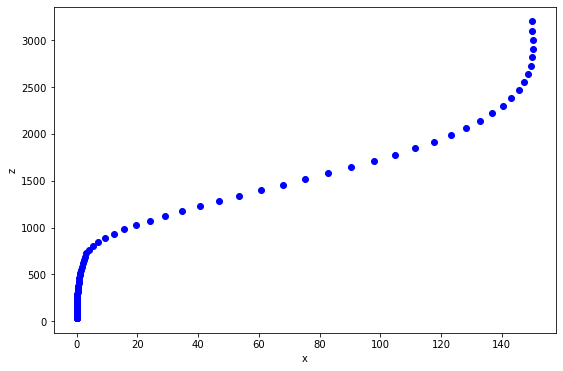

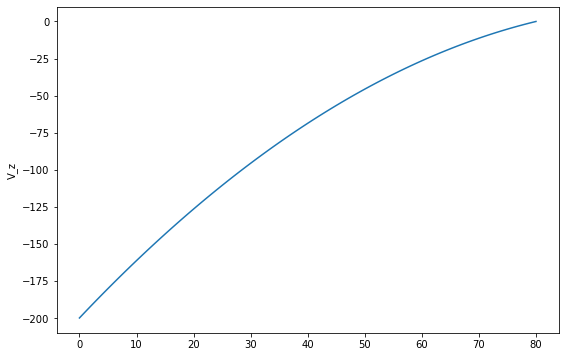

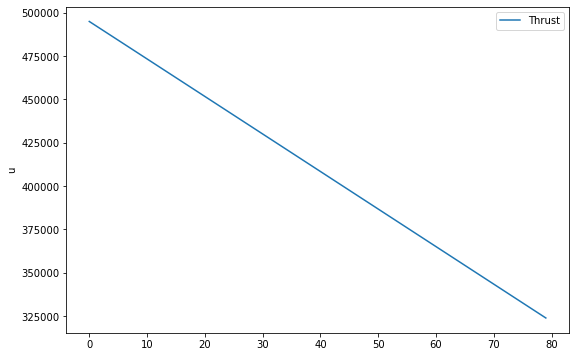

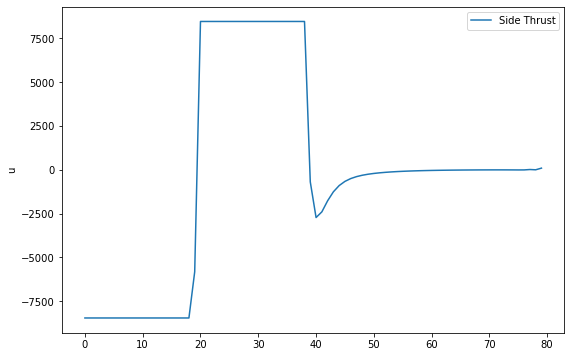

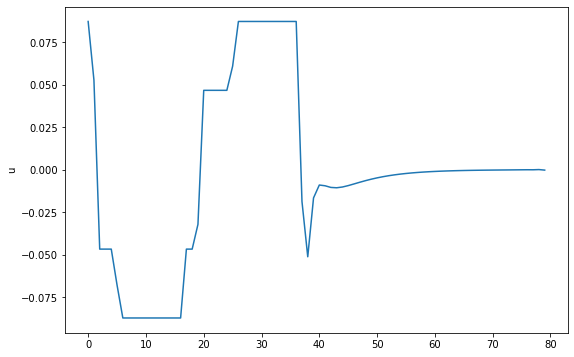

In [27]:
#These can generally be tuned
Q = np.diag([1000,1000,1000,10000,1000,10000,0]) #From team 14 example 
R = np.array([[100,0,0],[0,1/((5*np.pi/180)**2),0],[0,0,10000/(Fmax**2)]])
P = np.diag([1000,1000,1000,10000,1000,1000000,0])

Af = np.vstack((np.eye(7), -np.eye(7)))
# model = [th, omega, x, dx, z, dz, g]
bf = np.array([0, 0, 10, 0,35,0,9.81,    0, 0, 10, 0,-35,0,-9.81])
x0=np.array([0, 0, 150, 0, 3200,-200, 9.81])

N=80
[model, feas, xref, uref, JOpt] = solve_cftoc(A, B, P, Q, R, N, x0, 20*np.pi/180, 5*np.pi/180, Hu, Ku, bf, Af)
# print('JOpt=', JOpt)
# print('xOpt=', xOpt)
# print('uOpt=', uOpt)
# print(feas)
fig = plt.figure(figsize=(9, 6))
plt.plot(xref[2].T,xref[4].T,'bo')
plt.xlabel('x')
plt.ylabel('z')
fig = plt.figure(figsize=(9, 6))
plt.plot(xref[5].T)
plt.ylabel('V_z')
fig = plt.figure(figsize=(9, 6))
plt.plot(uref[0].T)
plt.ylabel('u')
plt.legend(['Thrust'])
plt.show()
fig = plt.figure(figsize=(9, 6))
plt.plot(uref[2].T)
plt.ylabel('u')
plt.legend(['Side Thrust'])
plt.show()
fig = plt.figure(figsize=(9, 6))
plt.plot(uref[1].T)
plt.ylabel('u')
plt.show()
xref = np.hstack((xref, np.tile(xref[:,-1], (6,1)).T))
uref = np.hstack((uref[:,:-1], np.tile(uref[:,-2], (6,1)).T))

In [28]:
# # trajectory generation
# time = np.arange(0,30, 0.1)
# print(len(time))
# x_traj = 1 + np.divide((5),(1+np.exp(-time)))
                       
# def trajectory_generation(t, state, desired_state, dt=0.1, horizon=30):
#     [theta_des, omega_des, x_des, dx_des, z_des, dz_des, g] = desired_state;
#     [theta, omega, x, dx, z, dz, g] = state;
#     time = np.arange(0,horizon, dt)
#     x_traj = x + np.divide((x_des-x),(1+np.exp(-time)))
#     dx_traj = (x_des - x)*ones((1, len(time)))
#     z_t = 1000*np.exp(-0.05*(time+t))
#     traj = np.empty((0, len(state)))
#     for t in np.arange(0,horizon, dt):
#         cur_des = np.array([theta*(0.3+np.exp(-x)

def solve_mpc(A, B, P, Q, R, N, x0, x1U, x2U, Hu, Ku, xref, uref, sl=0):
    # Setup the CFTOC 
    Af = np.vstack((np.eye(7), -np.eye(7)))
    eps = 10
    bf = np.concatenate((xref[:,-1]+eps, -xref[:,-1]+eps))
    model = pyo.ConcreteModel()
    model.N = N
    model.nx = np.size(A, 0)
    model.nu = np.size(B, 1)
    model.nf = np.size(Af, 0)
    model.nc = np.size(Hu, 0)
    
    # length of finite optimization problem:
    model.tIDX = pyo.Set( initialize= range(model.N+1), ordered=True )  
    model.xIDX = pyo.Set( initialize= range(model.nx), ordered=True )
    model.uIDX = pyo.Set( initialize= range(model.nu), ordered=True )    
    model.nfIDX = pyo.Set( initialize= range(model.nf), ordered=True )
    model.ncIDX = pyo.Set( initialize= range(model.nc), ordered=True )
    model.epsIDX = pyo.Set( initialize= range(4), ordered=True )

    
    # these are 2d arrays:
    model.A = A
    model.B = B
    model.Q = Q
    model.P = P
    model.R = R
    
    model.Hu = Hu
    model.Ku = Ku 
    
    model.xref = xref
    model.uref = uref  
    model.Af = Af
    model.bf = bf
    
    # Create state and input variables trajectory:
    model.x = pyo.Var(model.xIDX, model.tIDX)
    model.u = pyo.Var(model.uIDX, model.tIDX)
    model.eps = pyo.Var(model.epsIDX, model.tIDX, domain=pyo.NonNegativeReals) # Slack variable is introduced 
    
    #Objective:
    def objective_rule(model):
        costX = 0.0
        costU = 0.0
        costTerminal = 0.0
        slack = 0.0
        for t in model.tIDX:
            for i in model.xIDX:
                for j in model.xIDX:
                    if t < model.N:
                        costX += (model.x[i, t] - model.xref[i, t]) * model.Q[i, j] * (model.x[j, t] - model.xref[j, t]) 
        for t in model.tIDX:
            for i in model.uIDX:
                for j in model.uIDX:
                    if t < model.N:
                        costU += (model.u[i, t] - model.uref[i, t]) * model.R[i, j] * (model.u[j, t] - model.uref[j, t])
                        # costU += (model.u[i, t]) * model.R[i, j] * (model.u[j, t])
        for i in model.xIDX:
            for j in model.xIDX:               
                 costTerminal += (model.x[i, model.N] - model.xref[i, model.N]) * model.P[i, j] * (model.x[j, model.N] - model.xref[j, model.N])
        
        for t in model.tIDX:
            for i in model.epsIDX:
                for j in model.epsIDX:
                    if t < model.N:
                        slack += model.eps[i,t] * model.eps[j,t] # penalty on the slack variable (quadratic term)
                        slack += 1000*model.eps[i,t] # penalty on the slack variable (linear term)
        return costX + costU + costTerminal + slack
    
    model.cost = pyo.Objective(rule = objective_rule, sense = pyo.minimize)
    
    # Constraints:
    def equality_const_rule(model, i, t):
        return model.x[i, t+1] - (sum(model.A[i, j] * model.x[j, t] for j in model.xIDX)
                               +  sum(model.B[i, j] * model.u[j, t] for j in model.uIDX) ) == 0.0 if t < model.N else pyo.Constraint.Skip
    
    def input_const_rule(model, i, t):
        return sum(model.Hu[i, j] * model.u[j, t] for j in model.uIDX) <= model.Ku[i] if t < model.N else pyo.Constraint.Skip

    model.equality_constraints = pyo.Constraint(model.xIDX, model.tIDX, rule=equality_const_rule)
    model.init_const = pyo.Constraint(model.xIDX, rule=lambda model, i: model.x[i, 0] == x0[i])
    
    model.state_limit1 = pyo.Constraint(model.tIDX, rule=lambda model, t: model.x[0, t] <= x1U + model.eps[0,t]*sl
                                   if t < N else pyo.Constraint.Skip)
    model.state_limit2 = pyo.Constraint(model.tIDX, rule=lambda model, t: -x1U - model.eps[1,t]*sl <= model.x[0, t]
                                    if t < N else pyo.Constraint.Skip)
    
    model.state_limit3 = pyo.Constraint(model.tIDX, rule=lambda model, t: model.x[1, t] <= x2U + model.eps[2,t]*sl
                                if t < N else pyo.Constraint.Skip)
    model.state_limit4 = pyo.Constraint(model.tIDX, rule=lambda model, t: -x2U - model.eps[3,t]*sl <= model.x[1, t]
                                  if t < N else pyo.Constraint.Skip)
    model.state_limit5 = pyo.Constraint(model.tIDX, rule=lambda model, t: 34 <= model.x[4, t]
                                  if t < N else pyo.Constraint.Skip)
    
    model.input_const = pyo.Constraint(model.ncIDX, model.tIDX, rule=input_const_rule)
    
#     def final_const_rule(model, i):
#         return sum(model.Af[i, j] * model.x[j, model.N] for j in model.xIDX) <= model.bf[i]
#     model.final_const = pyo.Constraint(model.nfIDX, rule=final_const_rule)

    solver = pyo.SolverFactory('ipopt')
    results = solver.solve(model)
    
    if str(results.solver.termination_condition) == "optimal":
        feas = True
    elif sl < 3:
        print("Recalculating:", sl)
        [model, feas, xOpt, uOpt, JOpt] = solve_mpc(A, B, P, Q, R, N, x0, x1U, x2U, Hu, Ku, xref, uref, sl=sl+1)
    else:
        feas = False
            
    xOpt = np.asarray([[model.x[i,t]() for i in model.xIDX] for t in model.tIDX]).T
    uOpt = np.asarray([model.u[:,t]() for t in model.tIDX]).T
    JOpt = model.cost()
    #print(np.asarray([model.eps[:,t]() for t in model.tIDX]).T)
    
    return [model, feas, xOpt, uOpt, JOpt]

In [29]:
def simulate(x0, sim_length, sim_freq, xref, uref,Q,R,P):
    dt = 1.0/sim_freq
    nx = np.size(x0, 0)
    nu = np.size(uref, 0)
    M = sim_length*sim_freq
    N = 4
    xOpt = np.zeros((nx, M+1))
    uOpt = np.zeros((nu, M))
    xOpt[:, 0] = x0.reshape(nx, )
    xk = x0
    xPred = np.zeros((nx, N+1, M))
    predErr = np.zeros((nx, M-N+1))

    feas = np.zeros((M, ), dtype=bool)
    xN = np.zeros((nx,1))
    A, B = jacobian_dyn()
    
    for t in range(M):
        [model, feas[t], x, u, J] = solve_mpc(A, B, P, Q, R, N, xk, 20*np.pi/180, 10*np.pi/180, Hu, Ku, xref[:, t:t+N+1], uref[:, t:t+N+1])

#         if not feas[t]:
#             xOpt = []
#             uOpt = []
#             predErr = []
#             break
        # Save open loop predictions
        xPred[:, :, t] = x

        # Save closed loop trajectory
        # Note that the second column of x represents the optimal closed loop state
        # xOpt[:, t+1] = x[:, 1]
        uk = u[:, 0]
        uOpt[:, t] = u[:, 0].reshape(nu, )
        xk = PlantPredict(u[:, 0].flatten(), xk, False, 0.5)
        xOpt[:,t+1] = np.reshape(xk, (nx, ))
        A, B = numerical_diff(xk, uk)
        if xk[4] < 34:
            break
    return xOpt, uOpt, feas 

In [30]:
from skopt.utils import use_named_args
from skopt import gp_minimize
from skopt.space import Real, Categorical, Integer

ModuleNotFoundError: No module named 'skopt'

In [ ]:
#Define parameters, bounds and distribution
alpha_param = Real(low=0.075, high=0.125, prior='log-uniform',
                         name='alphaC')
beta_param = Real(low=0.4, high=0.6, prior='log-uniform',
                         name='betaC')
gamma_param = Real(low=4, high=6, prior='log-uniform',
                         name='gammaC')
delta_param = Real(low=1.5, high=2.5, prior='log-uniform',
                         name='deltaC')
dimensions = [alpha_param,
              beta_param,
              gamma_param,
              delta_param
              # dim_epochs
              ]
default_parameters = [0.1,0.5,5,2.0] #Initial Guess

In [ ]:
# Q = np.diag([100000000,1000000,10,10,10,10,0]) #From team 14 example 
# R = np.array([[1/(Fmax**2),0,0],[0,1/((5*np.pi/180)**2),0],[0,0,10000/(Fmax**2)]])
# P = Q
@use_named_args(dimensions=dimensions)
def objective(alphaC, betaC, gammaC, deltaC):
    # TODO: TUNE THIS
    
    #alphaC = 0.1
    #betaC = 0.5
    #gammaC = 5
    #deltaC= 2
    Wq = np.array([alphaC,betaC,gammaC,gammaC,betaC,1,0])
    Wr = np.array([deltaC,deltaC,betaC])
    Q = np.outer(Wq, Wq)
    R = np.outer(Wr, Wr)
    P = 3*Q
    
    np.set_printoptions(precision=8)
    x_real, u_real, feasibility = simulate(x0, 40, 2, xref, uref,Q,R,P)
    #Compute the stage cost over the simulation horizon 
    steps_sim =x_real.shape[1]
    nstates = x_real.shape[0]
    ninputs = u_real.shape[0]
    Real_Cost = 0.0
    CostX = 0.0
    CostU = 0.0

    for t in range(steps_sim):
        for i in range(nstates):
            for j in range(nstates):
                CostX += (x_real[i, t] - xref[i, t]) * model.Q[i, j] * (x_real[j, t] - xref[j, t]) 
    for t in range(steps_sim-1):
          for i in range(ninputs):
              for j in range(ninputs):
                  CostU += (u_real[i, t] - uref[i, t]) * model.R[i, j] * (u_real[j, t] - uref[j, t])
                            # costU += (model.u[i, t]) * model.R[i, j] * (model.u[j, t])
    Real_Cost =  CostX + costU
    
    if any(feasibility==False):
       Real_Cost = 300000000
    return Real_Cost
  

In [ ]:
gp_result = gp_minimize(func=objective,
                        dimensions=dimensions,
                        n_calls=50,
                        noise=1e-8,
                        n_jobs=-1,
                        acq_func="EI",
                        verbose=True,
                        x0=default_parameters)

opt_h = gp_result.x[0], gp_result.x[1], gp_result.x[2], gp_result.x[3]
print(opt_h)
print(gp_result.fun)
print(gp_result)

In [ ]:
gp_result.func_vals

In [ ]:
plt.figure(dpi=300)
plt.plot(gp_result.func_vals,'b-o')
plt.xlabel('Iteration')
plt.ylabel('Objective Value')

In [ ]:
opt_h

In [ ]:
# Q = np.diag([100000000,1000000,10,10,10,10,0]) #From team 14 example 
# R = np.array([[1/(Fmax**2),0,0],[0,1/((5*np.pi/180)**2),0],[0,0,10000/(Fmax**2)]])
# P = Q

Wq = np.array([opt_h[0],opt_h[1],opt_h[2],opt_h[2],opt_h[1],1,0])
Wr = np.array([opt_h[3],opt_h[3],opt_h[1]])
# TODO: TUNE THIS
#Wq = np.array([0.1,0.5,5,5,0.5,1,0])
#Wr = np.array([2,2,0.5])
Q = np.outer(Wq, Wq)
R = np.outer(Wr, Wr)
P = 3*Q

np.set_printoptions(precision=8)
x_realOpt, u_realOpt,feasibilityOpt = simulate(x0, 40, 2, xref, uref,Q,R,P)
fig = plt.figure(figsize=(9, 6))
plt.plot(x_realOpt[2].T,x_realOpt[4].T,'bo')
plt.xlabel('x')
plt.ylabel('z')
fig = plt.figure(figsize=(9, 6))
plt.plot(xref[4].T)
plt.ylabel('x_vel')
fig = plt.figure(figsize=(9, 6))
plt.plot(xref[5].T)
plt.ylabel('z_vel')
fig = plt.figure(figsize=(9, 6))
plt.plot(u_realOpt[0].T)
plt.ylabel('u')
plt.legend(['Thrust'])
plt.show()
fig = plt.figure(figsize=(9, 6))
plt.plot(u_realOpt[2].T)
plt.ylabel('u')
plt.legend(['Side Thrust'])
plt.show()
fig = plt.figure(figsize=(9, 6))
plt.plot(u_realOpt[1].T)
plt.ylabel('u')
plt.show()

In [ ]:
# Q = np.diag([100000000,1000000,10,10,10,10,0]) #From team 14 example 
# R = np.array([[1/(Fmax**2),0,0],[0,1/((5*np.pi/180)**2),0],[0,0,10000/(Fmax**2)]])
# P = Q
xrandom = gp_result.x_iters[4]
# TODO: TUNE THIS
Wq = np.array([xrandom[0],xrandom[1],xrandom[2],xrandom[2],xrandom[1],1,0])
Wr = np.array([xrandom[3],xrandom[2],xrandom[1]])
Q = np.outer(Wq, Wq)
R = np.outer(Wr, Wr)
P = 3*Q

np.set_printoptions(precision=8)
x_real, u_real,feasibility = simulate(x0, 40, 2, xref, uref,Q,R,P)
plt.figure(dpi=300)
plt.plot(x_real[2].T,x_real[4].T,'r--')
plt.plot(x_realOpt[2].T,x_realOpt[4].T,'g-')
plt.legend(['Nominal Parameters','Tuned Parameter'])
plt.xlabel('x')
plt.ylabel('z')

fig = plt.figure(figsize=(9, 6))
plt.plot(xref[4].T)
plt.ylabel('x_vel')
fig = plt.figure(figsize=(9, 6))
plt.plot(xref[5].T)
plt.ylabel('z_vel')

plt.figure(dpi=300)
plt.plot(u_real[0].T,'r-')
plt.plot(u_realOpt[0].T,'g-')
plt.ylabel('Thrust')
plt.xlabel('Steps')
plt.legend(['Nominal Parameters','Tuned Parameter'])
plt.show()

plt.figure(dpi=300)
plt.plot(u_real[2].T,'r-')
plt.plot(u_realOpt[2].T,'g-')
plt.ylabel('Side Thrust')
plt.xlabel('Steps')
plt.legend(['Nominal Parameters','Tuned Parameter'])
plt.show()

plt.figure(dpi=300)
plt.plot(u_real[1].T,'ro')
plt.plot(u_realOpt[1].T,'go')
plt.ylabel('u')
plt.show()

In [ ]:
feasibility

In [ ]:
gp_result.x_iters[26]

In [ ]:
Real_Cost

In [ ]:
uref[0]

In [ ]:
import matplotlib.pyplot as plt
# Plot animation
from matplotlib import animation, rc
from IPython.display import HTML

# --- MPC ON PLANT-- #
xOpt = x_real
uOpt = np.hstack((u_real, np.zeros((3,1))))
# Animation

lf = 35 

X1 = xOpt[2] + lf*np.sin(xOpt[0])
X2 = xOpt[2] + lf*np.sin(np.pi+xOpt[0])
X3 = X2 + np.multiply((100)*np.sin(np.pi+xOpt[0]), uOpt[0]/Fmax)
Y1 = xOpt[4] + lf*np.cos(xOpt[0])
Y2 = xOpt[4] + lf*np.cos(np.pi+xOpt[0])
Y3 = Y2 + np.multiply((100)*np.cos(np.pi+xOpt[0]), uOpt[0]/Fmax)

XL = X1 + np.multiply(10*np.cos(xOpt[0]), uOpt[2] < 0)
YL = Y1 - np.multiply(10*np.sin(xOpt[0]), uOpt[2] < 0)
XR = X1 - np.multiply(10*np.cos(xOpt[0]), uOpt[2] > 0)
YR = Y1 + np.multiply(10*np.sin(xOpt[0]), uOpt[2] > 0)

fig, ax = plt.subplots()
line, = ax.plot([], [], 'o-', lw=2)
line2, = ax.plot([], [], color = "r")
line3, = ax.plot([], [], color = "r")
line4, = ax.plot([], [], color = "r")

def animate(i,line,line2,line3,line4):
    thisx = [X1[i], X2[i]]
    thisy = [Y1[i], Y2[i]]
    leftx = [X1[i], XL[i]]
    lefty = [Y1[i], YL[i]]
    rx = [X1[i], XR[i]]
    ry = [Y1[i], YR[i]]
    tx = [X2[i], X3[i]]
    ty = [Y2[i], Y3[i]]
    dynamicWindowXMargin = 100
    dynamicWindowYMargin = 100
    ax.set_xlim(X1[i] - dynamicWindowXMargin, X1[i] + dynamicWindowXMargin) # Dynamic X lim
    ax.set_ylim(Y2[i] - dynamicWindowYMargin, Y2[i] + dynamicWindowYMargin) # Dynamic Y lim

    line.set_data(thisx, thisy)
    line2.set_data(leftx, lefty)
    line3.set_data(rx, ry)
    line4.set_data(tx, ty)
    return [line,line2,line2,line2]


ani = animation.FuncAnimation(fig, animate, range(1, len(xOpt[0])), fargs=[line, line2, line3, line4],
                  interval=100, blit=True)
rc('animation', html='jshtml')
ani



In [ ]:
# --- REFERENCE TRAJECTORY ON LINEARIZED PLANT-- #
xOpt = xref
uOpt = np.hstack((uref, np.zeros((3,1))))
# Animation

lf = 35 

X1 = xOpt[2] + lf*np.sin(xOpt[0])
X2 = xOpt[2] + lf*np.sin(np.pi+xOpt[0])
X3 = X2 + np.multiply((100)*np.sin(np.pi+xOpt[0]), uOpt[0]/Fmax)
Y1 = xOpt[4] + lf*np.cos(xOpt[0])
Y2 = xOpt[4] + lf*np.cos(np.pi+xOpt[0])
Y3 = Y2 + np.multiply((100)*np.cos(np.pi+xOpt[0]), uOpt[0]/Fmax)

XL = X1 + np.multiply(10*np.cos(xOpt[0]), uOpt[2] < 0)
YL = Y1 - np.multiply(10*np.sin(xOpt[0]), uOpt[2] < 0)
XR = X1 - np.multiply(10*np.cos(xOpt[0]), uOpt[2] > 0)
YR = Y1 + np.multiply(10*np.sin(xOpt[0]), uOpt[2] > 0)

fig, ax = plt.subplots()
line, = ax.plot([], [], 'o-', lw=2)
line2, = ax.plot([], [], color = "r")
line3, = ax.plot([], [], color = "r")
line4, = ax.plot([], [], color = "r")

def animate(i,line,line2,line3,line4):
    thisx = [X1[i], X2[i]]
    thisy = [Y1[i], Y2[i]]
    leftx = [X1[i], XL[i]]
    lefty = [Y1[i], YL[i]]
    rx = [X1[i], XR[i]]
    ry = [Y1[i], YR[i]]
    tx = [X2[i], X3[i]]
    ty = [Y2[i], Y3[i]]
    dynamicWindowXMargin = 100
    dynamicWindowYMargin = 100
    ax.set_xlim(X1[i] - dynamicWindowXMargin, X1[i] + dynamicWindowXMargin) # Dynamic X lim
    ax.set_ylim(Y2[i] - dynamicWindowYMargin, Y2[i] + dynamicWindowYMargin) # Dynamic Y lim

    line.set_data(thisx, thisy)
    line2.set_data(leftx, lefty)
    line3.set_data(rx, ry)
    line4.set_data(tx, ty)
    return [line,line2,line2,line2]


ani = animation.FuncAnimation(fig, animate, range(1, len(xOpt[0])), fargs=[line, line2, line3, line4],
                  interval=100, blit=True)
rc('animation', html='jshtml')
ani

In [ ]:
# --- REFERENCE TRAJECTORY ON PLANT -- #
def simulate_nocontrol(x0, sim_length, sim_freq, xref, uref):
    dt = 1.0/sim_freq
    nx = np.size(x0, 0)
    nu = np.size(uref, 0)
    M = sim_length*sim_freq
    N = 4
    xOpt = np.zeros((nx, M+1))
    uOpt = np.zeros((nu, M))
    xOpt[:, 0] = x0.reshape(nx, )
    xk = x0
    for t in range(M):
        uOpt[:, t] = uref[:, t].reshape(nu, )
        xk = PlantPredict(uref[:, t].flatten(), xk, False, 0.5)
        xOpt[:,t+1] = np.reshape(xk, (nx, ))
        if xk[4] < 34:
            break
    return xOpt, uOpt


xOpt, uOpt = simulate_nocontrol(x0,40,2, xref,uref)
uOpt = np.hstack((uOpt, np.zeros((3,1))))
# Animation

lf = 35 

X1 = xOpt[2] + lf*np.sin(xOpt[0])
X2 = xOpt[2] + lf*np.sin(np.pi+xOpt[0])
X3 = X2 + np.multiply((100)*np.sin(np.pi+xOpt[0]), uOpt[0]/Fmax)
Y1 = xOpt[4] + lf*np.cos(xOpt[0])
Y2 = xOpt[4] + lf*np.cos(np.pi+xOpt[0])
Y3 = Y2 + np.multiply((100)*np.cos(np.pi+xOpt[0]), uOpt[0]/Fmax)

XL = X1 + np.multiply(10*np.cos(xOpt[0]), uOpt[2] < 0)
YL = Y1 - np.multiply(10*np.sin(xOpt[0]), uOpt[2] < 0)
XR = X1 - np.multiply(10*np.cos(xOpt[0]), uOpt[2] > 0)
YR = Y1 + np.multiply(10*np.sin(xOpt[0]), uOpt[2] > 0)

fig, ax = plt.subplots()
line, = ax.plot([], [], 'o-', lw=2)
line2, = ax.plot([], [], color = "r")
line3, = ax.plot([], [], color = "r")
line4, = ax.plot([], [], color = "r")

def animate(i,line,line2,line3,line4):
    thisx = [X1[i], X2[i]]
    thisy = [Y1[i], Y2[i]]
    leftx = [X1[i], XL[i]]
    lefty = [Y1[i], YL[i]]
    rx = [X1[i], XR[i]]
    ry = [Y1[i], YR[i]]
    tx = [X2[i], X3[i]]
    ty = [Y2[i], Y3[i]]
    dynamicWindowXMargin = 100
    dynamicWindowYMargin = 100
    ax.set_xlim(X1[i] - dynamicWindowXMargin, X1[i] + dynamicWindowXMargin) # Dynamic X lim
    ax.set_ylim(Y2[i] - dynamicWindowYMargin, Y2[i] + dynamicWindowYMargin) # Dynamic Y lim

    line.set_data(thisx, thisy)
    line2.set_data(leftx, lefty)
    line3.set_data(rx, ry)
    line4.set_data(tx, ty)
    return [line,line2,line2,line2]


ani = animation.FuncAnimation(fig, animate, range(1, len(xOpt[0])), fargs=[line, line2, line3, line4],
                  interval=100, blit=True)
rc('animation', html='jshtml')
ani